In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle5 as pickle
import os, sys, warnings
import xarray as xr
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
sys.path.append(os.path.abspath("/groups/sylvia/nawdex-hackathon/shared/"))
sys.path.append(os.path.abspath("/groups/sylvia/nawdex-hackathon/utilities/"))
from domain_mean_utilities import *
import dict_nawdexsims
# simulations dictionary
simdict = dict_nawdexsims.simdictionary()
# dictionary for the days to be analyzed
anadaysdict = dict_nawdexsims.anadaysdictionary()

In [3]:
def colordictionary():
    # manually defined colors
    mymaroon= np.array([128,   0,   0])/255
    myred   = np.array([230,  25,  75])/255
    myorange= np.array([245, 130,  48])/255
    mymagenta=np.array([240, 50, 230 ])/255
    myolive = np.array([128, 128,   0])/255
    myteal  = np.array([  0, 128, 128])/255
    myblue  = np.array([  0, 130, 200])/255
    mynavy  = np.array([  0,   0, 128])/255

    return {'80' : mymaroon, '40' : myred, '20' : myorange, '10' : myolive, '5' : myteal, '2' : myblue}

farbe = colordictionary()

# Figure S1: Sensitivity in occurrence probability to cloud fraction thresholds

In [18]:
file = '/groups/sylvia/nawdex-hackathon/occurrence_data/cloud_class_occurrence_no_weighting.pkl'
with open(file, "rb") as fh:
      A_df = pickle.load(fh)

A_df['Cloud class'].replace( {'HI': 'High', 'MED': 'Middle', 'LO': 'Low', 'H-M': 'High-x-Middle', 'M-L': 'Middle-x-Low',
                             'H-L': 'High-Low', 'H-M-L': 'High-x-Middle-x-Low'},
                            inplace=True )

class_names = ['High', 'Middle', 'Low', 'High-x-Middle', 'Middle-x-Low', 'High-Low', 'High-x-Middle-x-Low', 'Clear-sky']

Text(0.5, 0, 'Cloud class')

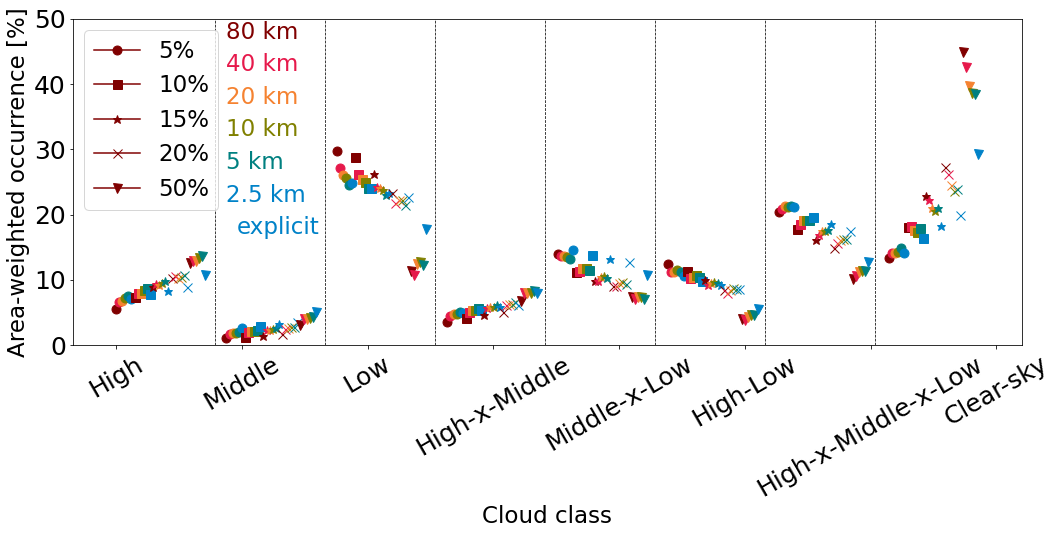

In [30]:
# Visualize the different thresholds in the same plot
fs = 20
fig = plt.figure(figsize=(17,6))
symbol = {'thr1' : 'o', 'thr2' : 's', 'thr3' : '*', 'thr4' : 'x', 'thr5' : 'v'}
thresholds = ['5%','10%','15%','20%','50%']
resolutions = ['80','40','20','10','5','2']

# Store the mean occurrences here for 5 thresholds, 6 resolutions, and 8 classes.
mean_occ = np.zeros((5,6,8))
i = 0
for t_indx, t in enumerate(['thr1','thr2','thr3','thr4','thr5']):
    for r_indx, r in enumerate(resolutions):
        for c_indx, cloud_class in enumerate(class_names):
            value = A_df[(A_df['Resolution'] == r) & (A_df['Cloud class'] == cloud_class)]['Occurrence_' + t].mean()
            mean_occ[t_indx,r_indx,c_indx] = value
            if r == '80' and c_indx == 0:
                plt.plot((c_indx+1)*10+i, value, color=farbe[r], markersize=9, marker=symbol[t],label=thresholds[t_indx])
            else:
                plt.plot((c_indx+1)*10+i, value, color=farbe[r], markersize=9, marker=symbol[t],label='_nolegend_')
            i = i+0.035
            
for i_indx,i in enumerate(np.arange(19,89,10)):
    plt.plot([i,i],[0,50],color='k',linestyle='--',linewidth=0.75)
    if i_indx < 6:
        if resolutions[i_indx] == '2':
            stringy = '2.5 km'
        else:
            stringy = str(resolutions[i_indx])+' km'
        plt.text(20, 47-5*i_indx, stringy, fontsize=fs+3, color=farbe[resolutions[i_indx]])
plt.text(21, 17, 'explicit', fontsize=fs+3, color=farbe[resolutions[i_indx-1]])
    
plt.gca().set_xticks(np.linspace(10,90,8))
plt.gca().set_xticklabels(class_names,rotation=30,fontsize=fs+5)
plt.gca().tick_params(axis="y", labelsize=fs+5)
plt.gca().set_ylabel('Area-weighted occurrence [%]',fontsize=fs+3)
plt.legend(loc='upper left',fontsize=fs+3)
plt.ylim([0,50])
plt.gca().set_xlabel('Cloud class',fontsize=fs+3)

#plt.savefig( '/groups/sylvia/nawdex-hackathon/figs/occurrence_sensitivity_to_thresholds.pdf', bbox_inches='tight' )

# Figure S2: Net CRH from all simulations for one period not all

In [31]:
sim_set_2 = []

for sim in list(simdict.keys()):
    path = '/groups/sylvia/nawdex-hackathon/domain-mean_data/radiative_heating_domain_mean/'
    
    # only the simulations start at 22092016
    if simdict[sim]['start'] == '20160922':
        
        ds = xr.open_dataset(path+'atmradheating_fldmean_openocean_'+sim+'.nc')
        
        # deriving the lw, sw and net cloud radiative heating rates
        
        ds['lw_crh'] = ds['ddt_temp_radlw_fromflux'] - ds['ddt_temp_radlwclr_fromflux']
        ds['sw_crh'] = ds['ddt_temp_radsw_fromflux'] - ds['ddt_temp_radswclr_fromflux']
        ds['nt_crh'] = ds['lw_crh'] + ds['sw_crh']
        
        ds.attrs['simulation'] = sim
    
        # Only the selected days
        startday  = simdict[sim]['start']
        anadays = anadaysdict[startday]

        ds = ds.sel(time=slice(anadays[0], anadays[-1]))
     
        sim_set_2.append(ds)
    
        del sim

In [54]:
# function for plotting vertical profiles
def plot_thmean(_ds_icon_list, _var, num):
    fs = 20
    let = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
    for ds in _ds_icon_list:
        #print(ds.attrs['simulation'])
        # get plotting color according to ICON resolution
        pcolor = colordict[simdict[ds.attrs['simulation']]['res'][:-2]]
        # get linestyle according to convection scheme
        conv = simdict[ds.attrs['simulation']]['conv']
        if conv == 0:
            lstyle = '--'
        elif conv == 1:
            lstyle = '-'
        elif conv==2:
            lstyle = ':'

        if conv == 0 and simdict[ds.attrs['simulation']]['res'] != '2km':
            continue
        if conv == 1 and simdict[ds.attrs['simulation']]['res'] == '2km':
            continue
        
        mphys = simdict[ds.attrs['simulation']]['mphys']
        line = ds[_var].sel( height=slice(16,50) ).mean( 'time' )
        dailymean = ds[_var].sel( height=slice(16,50) ).groupby('time.day').mean('time')
        std_height = np.std( dailymean, axis=0 )
        ste_height = std_height/np.sqrt( np.size(dailymean['day']) )

        ax[mphys-1, num].tick_params( labelsize=fs, rotation=45 )
        ax[mphys-1, num].spines['left'].set_bounds( 5, 15 )
        ax[mphys-1, num].set_ylim( [5, 15] )
        ax[mphys-1, num].yaxis.set_ticks( [5, 7, 9, 11, 13, 15] )
        ax[mphys-1, num].yaxis.set_ticklabels( [5, 7, 9, 11, 13, 15], fontsize=fs)
        ax[mphys-1, num].spines['top'].set_color( 'none' )
        ax[mphys-1, num].spines['right'].set_color( 'none' )
        ax[mphys-1, num].spines['left'].set_color( 'none' )
        ax[mphys-1, num].axvline( x=0, ymin=0.0, ymax=1,c='black', lw=1 )
        if simdict[ds.attrs['simulation']]['res'] == '2km' and conv == 0:
            lbl = '2.5 km \n explicit'
        elif simdict[ds.attrs['simulation']]['res'] == '2km' and conv == 2:
            lbl = '2.5 km \n shallow \n on'
        else:
            lbl = simdict[ds.attrs['simulation']]['res']
        ax[mphys-1, num].plot( line.values*86400, zfull[0][15:50]/1e3, color=pcolor, linestyle=lstyle,
                 linewidth=2, label=lbl )
                
        if simdict[ds.attrs["simulation"]]["res"] == "80km":
            ax[mphys-1, num].fill_betweenx(y = zfull[0][15:50]/1e3, x1=(line-std_height)*86400,
                              x2=(line+std_height)*86400, color = pcolor, alpha=0.2) 
            ax[mphys-1, num].fill_betweenx(y = zfull[0][15:50]/1e3, x1=(line-ste_height)*86400,
                              x2=(line+ste_height)*86400, color = pcolor, alpha=0.3)
        if num == 0:
            ax[mphys-1, num].spines['bottom'].set_bounds( -0.3, 0.3 )
            ax[mphys-1, num].set_xlim( -0.3, 0.3 )
            ax[mphys-1, num].set_ylabel( "Height (km)", fontsize=fs )
            ax[mphys-1, num].text( 0.02, 1.02, let[num+(mphys-1)*3], fontsize=fs+3, transform=ax[mphys-1,num].transAxes )
            if mphys == 2:
                ax[mphys-1, num].set_xlabel( 'SW cloud radiative' '\n' r'heating (K day$^{-1}$)', fontsize=fs )
        if num == 1:
            ax[mphys-1, num].spines['bottom'].set_bounds( -0.5, 0.5 )
            ax[mphys-1, num].set_xlim( -0.5, 0.5 )
            ax[mphys-1, num].text( 0.02, 1.02, let[num+(mphys-1)*3], fontsize=fs+3, transform=ax[mphys-1,num].transAxes )
            if mphys == 2:
                ax[mphys-1, num].set_xlabel( 'LW cloud radiative' '\n' r'heating (K day$^{-1}$)', fontsize=fs )
        if num == 2:
            ax[mphys-1, num].spines['bottom'].set_bounds( -0.4, 0.4 )
            ax[mphys-1, num].set_xlim( -0.4, 0.4 )
            ax[mphys-1, num].text( 0.02, 1.02, let[num+(mphys-1)*3], fontsize=fs+3, transform=ax[mphys-1,num].transAxes )
            if mphys == 2:
                ax[mphys-1, num].set_xlabel( 'Net cloud radiative' '\n' r'heating (K day$^{-1}$)', fontsize=fs )
                            
        #elif mphys==2:
            
            
    ax[0, 0].legend( fontsize=fs-2, frameon=False, loc='upper left' )
    fig.tight_layout()    
    fig.text(-0.37, 0.52, '1-moment', rotation='vertical', ha='center', va='center', weight='bold',
         fontsize=fs, transform=ax[0,0].transAxes)
    fig.text(-0.37, 0.52, '2-moment', rotation='vertical', ha='center', va='center', weight='bold',
         fontsize=fs, transform=ax[1,0].transAxes)         
           

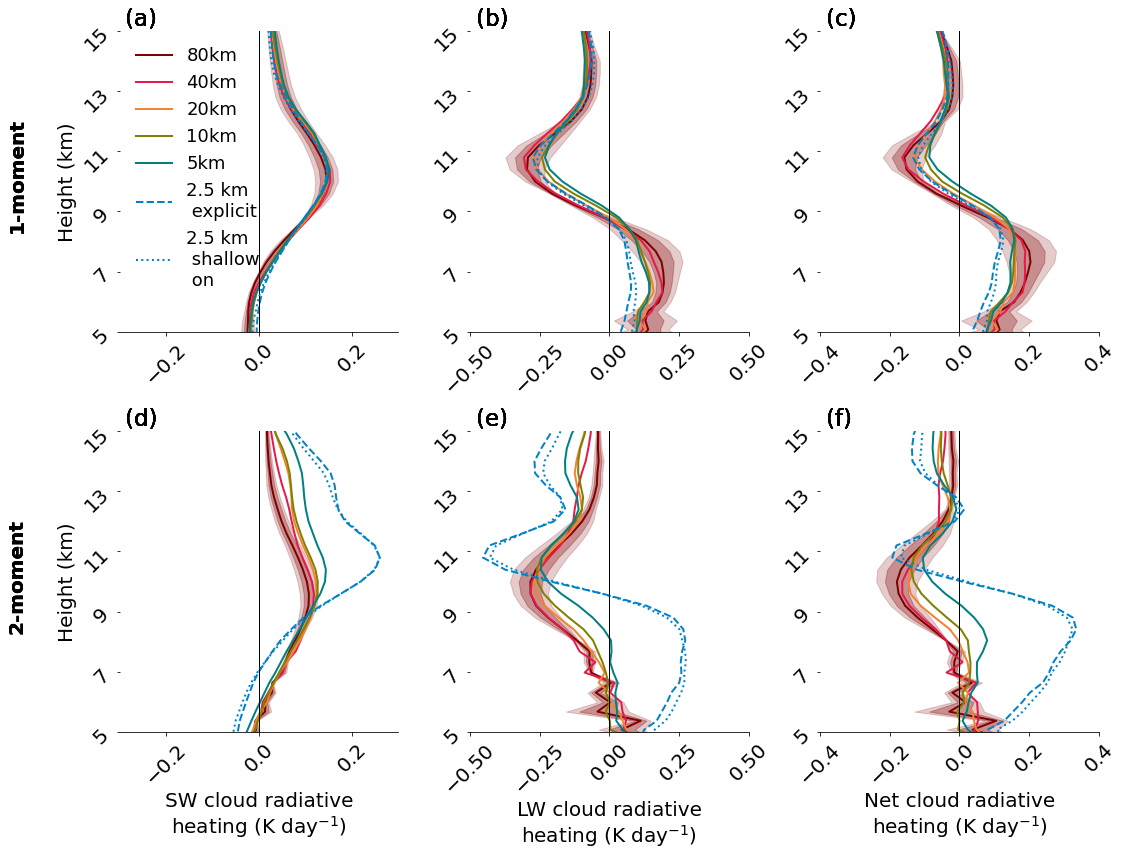

In [56]:
# vertical profiles of cloud-rad heating rates: all resolution and different microphysics for 1 period
zfull = get_fulllevel_height()
fig, ax = plt.subplots( nrows=2, ncols=3, figsize=(15, 12) )
for i, var in enumerate(['sw_crh','lw_crh','nt_crh']):
    plot_thmean( sim_set_2, var, i )
    
fig.savefig( '/groups/sylvia/nawdex-hackathon/figs/netcrh-clim-all_20160922.pdf', bbox_inches = 'tight', dpi=600 )

# Figure S3: Box plots of cloud class occurrence - 1 mom microphysics

In [20]:
# Save the occurrence dataframe in a pickle (or load it).
import pickle5 as pickle
file = '/groups/sylvia/nawdex-hackathon/occurrence_data/cloud_class_occurrence_area_weighting_mp1.pkl'
with open(file, "rb") as fh:
      A_df = pickle.load(fh)

A_df['Cloud class'].replace( {'HI': 'High', 'MED': 'Middle', 'LO': 'Low', 'H-M': 'High-x-Middle', 'M-L': 'Middle-x-Low',
                             'H-L': 'High-Low', 'H-M-L': 'High-x-Middle-x-Low'},
                            inplace=True )
A_df['Resolution'].replace( {'80km': '80', '40km': '40', '20km': '20', '10km': '10', '5km': '5', '2km': '2'},
                            inplace=True )

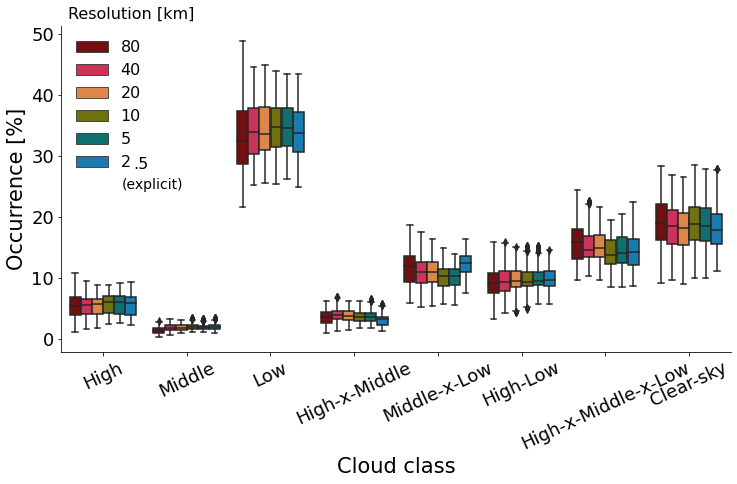

In [24]:
fs = 18
resolutions = ['80','40','20','10','5','2']
#resolutions = ['80km','40km','20km','10km','5km','2km']

# Plot the spatiotemporal probability distribution of the different classes for a threshold of 10%.
fig = plt.figure( figsize=(12,6) )
ax = sns.boxplot( x='Cloud class', y='Occurrence_thr1', hue='Resolution', data=A_df, hue_order=resolutions, palette=farbe )
ax.set_xticklabels( ax.get_xticklabels(), rotation=25, fontsize=fs )
ax.tick_params( axis="y", labelsize=fs )
ax.set_ylabel( 'Occurrence [%]', fontsize=fs+3 )
ax.set_xlabel( 'Cloud class', fontsize=fs+3 )
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.legend( frameon=False, fontsize=fs-2 )
ax.text( 0.01, 1.02, 'Resolution [km]', fontsize=fs-2, transform=ax.transAxes )
ax.text( 0.107, 0.56, '.5', fontsize=fs-2, transform=ax.transAxes )
ax.text( 0.09, 0.5, '(explicit)', fontsize=fs-4, transform=ax.transAxes )

fig.savefig('/groups/sylvia/nawdex-hackathon/figs/cloudclass_occurrence_mp1.pdf', bbox_inches='tight')

# Figure S4: Cloud fraction profiles for various cloud classes

In [4]:
# all classes, all heights, both microphysics schemes in one figure
fs = 20
mphysics = [1, 2]
var = 'clc'
threshold = 'hq62_mq67_lq30'
ipath = '/groups/sylvia/nawdex-hackathon/cloudclass_data/' + \
        'cloudprops_for_cloudclass/' + threshold + '/'
resolutions = ['80km', '40km', '20km', '10km', '5km', '2km', '2km-shcon']

In [6]:
# cloud classes
ncclass = 8 # number of cloud classes
cclasses = ['High', 'Middle', 'Low',
            'High-x-Middle', 'Middle-x-Low', 'High-Low', 'High-x-Middle-x-Low', 'Clear Sky']
cclass_save = ['H', 'M', 'L', 'H-x-M', 'M-x-L', 'H-L', 'H-x-M-x-L', 'clearsky']

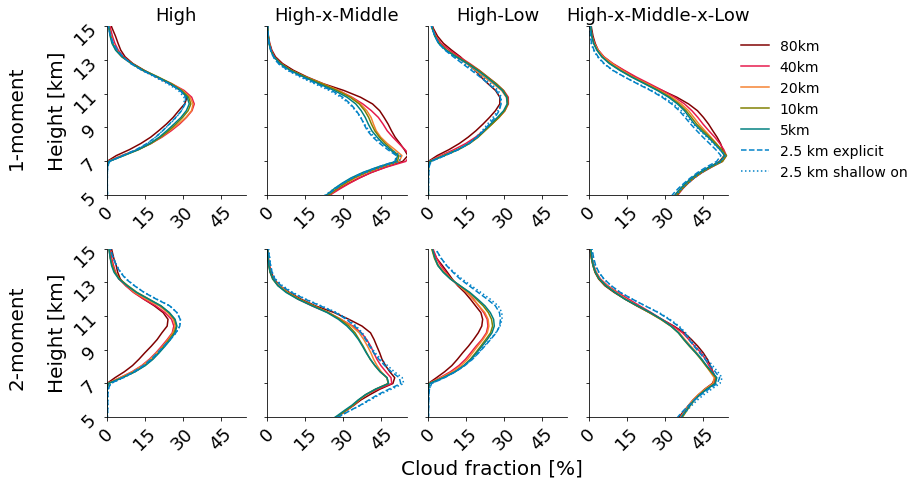

In [14]:
# open figure, add lines with each iteration over the resolutions
# and cloud classes
zfull = get_fulllevel_height()
fig, ax = plt.subplots(2, 4, figsize=(12, 6.5), sharey=True)
for mphys in mphysics:
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == mphys]

        # read cloud cover from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(ipath + expid + \
                                '_cloudproperties_cloudclasses_' + \
                                'areamean_timemean_oceanmask_applied_' + \
                                threshold + '.nc')
            data.append(ds)
        del ds

        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')
        del data, expid

        for i, c in enumerate([0, 3, 5, 6]): #range(ncclass):
            if res == '2km' and conv == 0:
                lbl = '2.5 km explicit'
            elif res == '2km' and conv == 2:
                lbl = '2.5 km shallow on'
            else:
                lbl = res
                
            ax[mphys-1, i].plot(ds[var + '_cclass' + str(c+1)], zfull[0]/1000,
                            color=colordict[res], linestyle=lstyle, label=lbl)
            ax[mphys-1, i].tick_params(labelsize=fs-2, rotation=45)
            ax[mphys-1, i].spines['right'].set_color('none')
            ax[mphys-1, i].spines['top'].set_color('none')
            #ax[c].spines['left'].set_position('zero')
            ax[mphys-1, i].set_yticks(np.arange(1, 31, 2))
            ax[mphys-1, i].set_ylim(5, 15) #(5, 15)#(0, 17)
            #if ax[mphys-1, c].get_ylim() == (0.0, 17.0):
            #ax[mphys-1, i].axhline(5, linewidth=1, color='k')
            #ax[mphys-1, i].axhline(15, linewidth=1, color='k')
            #ax[mphys-1, i].ticklabel_format(axis='x', scilimits=(-2,-2))
            ax[mphys-1, i].set_xticks([0, 15, 30, 45])
            ax[mphys-1, i].set_xlim(0, 55)
            ax[0, i].set_title(cclasses[c], fontsize=fs-2)
        del c
        del ds
    del res
del mphys

ax[0,3].legend( frameon=False, fontsize=fs-6, bbox_to_anchor=(1,1) )
fig.tight_layout()

# legend: text for lines
#xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
#for r, res in enumerate(resolutions[:-1]):
#    if resolutions[r] == '2km':
#        fig.text(xloc[r], -0.08, '2.5km', color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')
#    else:
#        fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')
#del r, res, xloc

ax[0, 0].set_ylabel('Height [km]', fontsize=fs)
ax[1, 0].set_ylabel('Height [km]', fontsize=fs)
fig.text(0.5, -0.01, 'Cloud fraction [%]',
            rotation='horizontal', ha='center', va='center', fontsize=fs)
fig.text(-0.05, 0.74, '1-moment',
            rotation='vertical', ha='center', va='center', fontsize=fs)
fig.text(-0.05, 0.27, '2-moment',
            rotation='vertical', ha='center', va='center', fontsize=fs)
        
plt.show(fig)
fig.savefig('/groups/sylvia/nawdex-hackathon/figs/clc_cloudclass.pdf', bbox_inches = 'tight', dpi=600)

# Figure S5: Graupel mass mixing ratio (1 mom) and snow mass mixing ratio (2 mom)

In [36]:
# all classes, all heights, both microphysics schemes in one figure
fs = 20
var = ['qg' ]
mphys = [ 1 ]
vardir = [  'qg_qnx_for_cloudclass/' ]
prefix = [ '_qg_qnx' ]
threshold = 'hq62_mq67_lq30'
ipath = [ '/groups/sylvia/nawdex-hackathon/cloudclass_data/' + i + '/' for i in vardir ]
resolutions = ['80km', '40km', '20km', '10km', '5km', '2km', '2km-shcon']
cclasses = ['High', 'Middle', 'Low',
            'High-x-Middle', 'Middle-x-Low', 'High-Low', 'High-x-Middle-x-Low', 'Clear Sky']
cclass_save = ['H', 'M', 'L', 'H-x-M', 'M-x-L', 'H-L', 'H-x-M-x-L', 'clearsky']
zfull = get_fulllevel_height()

qg 1
0.005992631043038322
0.010304982761079617
0.01894459599886462
0.026788020677511508
0.02709916676417837
0.2579306386372786
0.14508905963402743


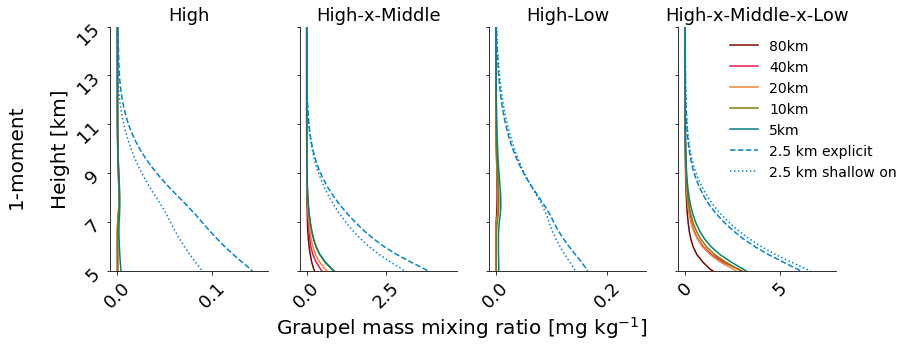

In [58]:
# open figure, add lines with each iteration over the resolutions
# and cloud classes
fig, ax = plt.subplots(1, 4, figsize=(13, 4.5), sharey=True)
for v, vdir, p, m in zip(var, ipath, prefix, mphys):
    print( v, m )
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == m]
        
        # read cloud cover from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(vdir + expid + p + '_cloudclasses_' + \
                                'areamean_timemean_oceanmask_applied_' + \
                                threshold + '.nc')
            data.append(ds)
        del ds

        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')
        del data, expid

        for i, c in enumerate([0, 3, 5, 6]):
            if res == '2km' and conv == 0:
                lbl = '2.5 km explicit'
            elif res == '2km' and conv == 2:
                lbl = '2.5 km shallow on'
            else:
                lbl = res
                
            ax[i].tick_params(labelsize=fs-2, rotation=45)
            ax[i].spines['right'].set_color('none')
            ax[i].spines['top'].set_color('none')
            ax[i].set_yticks(np.arange(1, 31, 2))
            ax[i].set_ylim(5, 15)
            ax[i].set_title(cclasses[c], fontsize=fs-2)
            ax[i].plot(ds[v + '_cclass' + str(c+1)]*10**6, zfull[0]/1000,
                            color=colordict[res], linestyle=lstyle, label=lbl)
            if c == 5:
                print( np.nanmax(ds[v + '_cclass' + str(c+1)]*10**6) )
            #ax[m-1, i].set_xlim( [0, 8] )
            #ax[m-1, i].set_xticks( [0, 2, 4, 6, 8] )
            
                #if c == 0 or c == 5:
                #    ax[m-1, i].set_xlim( [0, 8] )
                #    ax[m-1, i].set_xticks( [0, 2, 4, 6, 8] )
                #else:
                #    ax[m-1, i].set_xlim( [0, 80] )
                #    ax[m-1, i].set_xticks( [0, 20, 40, 60, 80] )

                    
ax[3].legend( frameon=False, fontsize=fs-6, bbox_to_anchor=(0.25,1.0) )
# legend: text for lines
#xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
#for r, res in enumerate(resolutions[:-1]):
#    if resolutions[r] == '2km':
#        fig.text(xloc[r], -0.08, '2.5km', color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')
#    else:
#        fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')

ax[0].set_ylabel('Height [km]', fontsize=fs)
fig.text(0.5, -0.05, 'Graupel mass mixing ratio [mg kg$^{-1}$]', rotation='horizontal', ha='center',
         va='center', fontsize=fs)
fig.text(0.025, 0.48, '1-moment',
            rotation='vertical', ha='center', va='center', fontsize=fs)

fig.savefig('/groups/sylvia/nawdex-hackathon/figs/qg_cloudclass.pdf', bbox_inches = 'tight', dpi=600)
plt.show()

 ################################

In [25]:
# all classes, all heights, both microphysics schemes in one figure
fs = 20
var = ['qg', 'qs']
mphys = [ 1, 2 ]
vardir = [  'qg_qnx_for_cloudclass/', 'qs_qr_for_cloudclass/' ]
prefix = [ '_qg_qnx', '_qs_qr' ]
threshold = 'hq62_mq67_lq30'
ipath = [ '/groups/sylvia/nawdex-hackathon/cloudclass_data/' + i + '/' for i in vardir ]
resolutions = ['80km', '40km', '20km', '10km', '5km', '2km', '2km-shcon']
cclasses = ['High', 'Middle', 'Low',
            'High-x-Middle', 'Middle-x-Low', 'High-Low', 'High-x-Middle-x-Low', 'Clear Sky']
cclass_save = ['H', 'M', 'L', 'H-x-M', 'M-x-L', 'H-L', 'H-x-M-x-L', 'clearsky']
zfull = get_fulllevel_height()

qg 1
qs 2


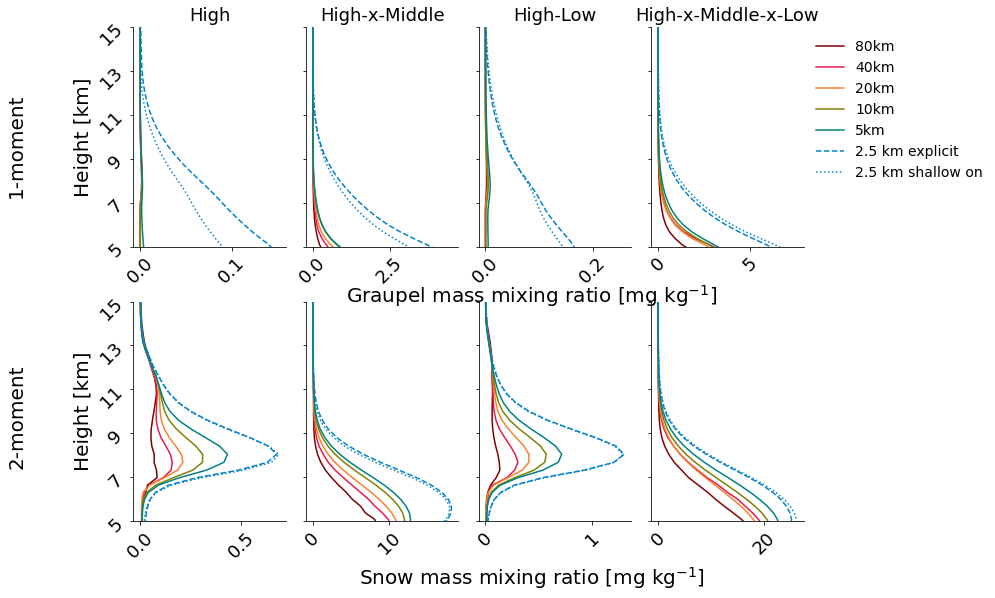

In [35]:
# open figure, add lines with each iteration over the resolutions
# and cloud classes
fig, ax = plt.subplots(2, 4, figsize=(13, 8), sharey=True)
for v, vdir, p, m in zip(var, ipath, prefix, mphys):
    print( v, m )
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == m]
        
        # read cloud cover from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(vdir + expid + p + '_cloudclasses_' + \
                                'areamean_timemean_oceanmask_applied_' + \
                                threshold + '.nc')
            data.append(ds)
        del ds

        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')
        del data, expid

        for i, c in enumerate([0, 3, 5, 6]):
            if res == '2km' and conv == 0:
                lbl = '2.5 km explicit'
            elif res == '2km' and conv == 2:
                lbl = '2.5 km shallow on'
            else:
                lbl = res
                
            ax[m-1, i].tick_params(labelsize=fs-2, rotation=45)
            ax[m-1, i].spines['right'].set_color('none')
            ax[m-1, i].spines['top'].set_color('none')
            ax[m-1, i].set_yticks(np.arange(1, 31, 2))
            ax[m-1, i].set_ylim(5, 15)
            ax[0, i].set_title(cclasses[c], fontsize=fs-2)
            ax[m-1, i].plot(ds[v + '_cclass' + str(c+1)]*10**6, zfull[0]/1000,
                            color=colordict[res], linestyle=lstyle, label=lbl)
            #ax[m-1, i].set_xlim( [0, 8] )
            #ax[m-1, i].set_xticks( [0, 2, 4, 6, 8] )
            
                #if c == 0 or c == 5:
                #    ax[m-1, i].set_xlim( [0, 8] )
                #    ax[m-1, i].set_xticks( [0, 2, 4, 6, 8] )
                #else:
                #    ax[m-1, i].set_xlim( [0, 80] )
                #    ax[m-1, i].set_xticks( [0, 20, 40, 60, 80] )

                    
ax[0,3].legend( frameon=False, fontsize=fs-6, bbox_to_anchor=(1.0,1.0) )
# legend: text for lines
#xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
#for r, res in enumerate(resolutions[:-1]):
#    if resolutions[r] == '2km':
#        fig.text(xloc[r], -0.08, '2.5km', color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')
#    else:
#        fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
#                ha='left', va='center', rotation='horizontal', fontsize=fs,
#                backgroundcolor='white')

ax[0, 0].set_ylabel('Height [km]', fontsize=fs)
ax[1, 0].set_ylabel('Height [km]', fontsize=fs)
fig.text(0.5, -0.01, 'Snow mass mixing ratio [mg kg$^{-1}$]', rotation='horizontal', ha='center',
         va='center', fontsize=fs)
fig.text(0.5, 0.48, 'Graupel mass mixing ratio [mg kg$^{-1}$]', rotation='horizontal', ha='center',
         va='center', fontsize=fs)
fig.text(-0.05, 0.27, '2-moment',
            rotation='vertical', ha='center', va='center', fontsize=fs)
fig.text(-0.05, 0.74, '1-moment',
            rotation='vertical', ha='center', va='center', fontsize=fs)
fig.tight_layout()     
plt.subplots_adjust(hspace=0.25)

#fig.savefig('/groups/sylvia/nawdex-hackathon/figs/qg_qs_cloudclass.pdf', bbox_inches = 'tight', dpi=600)
plt.show()